# Post-Block Survey

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import plot_likert
import scikit_posthocs as ph
import scipy.stats as stats
import seaborn as sns

%env OUTDATED_IGNORE=1
%run ./Plots.ipynb

sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['patch.linewidth'] = 0.0

palette = sns.color_palette("magma", 4)

env: OUTDATED_IGNORE=1


# 1. Read Data

In [2]:
# Read raw data
df = pd.read_excel("PostTask.xlsx")

# Drop unused columns
df.drop(df.filter(regex='Start time').columns, axis=1, inplace=True)
df.drop(df.filter(regex='Completion time').columns, axis=1, inplace=True)
df.drop(df.filter(regex='Email').columns, axis=1, inplace=True)
df.drop(df.filter(regex='Name').columns, axis=1, inplace=True)

# Rename columns
df.columns = ["Row", "Participant", "Task", "Technique",
              "Acquire", "Control", "Move", "Disengage", "Satisfaction", "Retain", "Responsive",
              "TLX_Mental", "TLX_Physical", "TLX_Temporal", "TLX_Performance", "TLX_Effort", "TLX_Frustration"]

# Replace Likert scale text with numbers
df.replace({"Very Strongly Disagree": 1, "Strongly Disagree": 2, "Disagree": 3, "Neither Agree or Disagree": 4,
           "Agree": 5, "Strongly Agree": 6, "Very Strongly Agree": 7}, inplace=True)

# Replace condition and task names
df.replace({"Touch In The Air": "AirTouch", "Pinch On Circle": "Pinch", "Pinch Anywhere": "PinchAnywhere"}, inplace=True)
df.replace({"Digit Selector": "Digit", "Letter Selector": "Letter", "Shape Scaler": "Shape"}, inplace=True)

# Calculate total task-load index
df["TLX"] = (df.TLX_Mental + df.TLX_Physical + df.TLX_Temporal + df.TLX_Performance + df.TLX_Effort + df.TLX_Frustration) / 60.0 * 10

df = df[df["Participant"] > 4]

n = len(df.Participant.unique())

print("Read data from {} participants".format(n,))

Read data from 15 participants


# 2. TLX


In [3]:
# Aggregate mean TLX data per participant
df_tlx = df.groupby(["Participant", "Technique"]).aggregate({"TLX": "mean",
                                                  "TLX_Mental": "mean",
                                                  "TLX_Physical": "mean",
                                                  "TLX_Temporal": "mean",
                                                  "TLX_Performance": "mean",
                                                  "TLX_Effort": "mean",
                                                  "TLX_Frustration": "mean"}).reset_index()

# Create separate arrays for each technique
df_airtouch = df_tlx[df_tlx['Technique'] == "AirTouch"]
df_dwell    = df_tlx[df_tlx['Technique'] == "Dwell"]
df_pinch    = df_tlx[df_tlx['Technique'] == "Pinch"]
df_pinchany = df_tlx[df_tlx['Technique'] == "PinchAnywhere"]

## 2.1 Plot TLX Data

[(0.0, 10.0)]

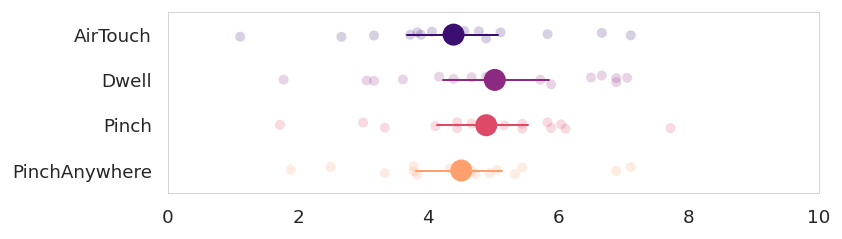

In [4]:
plot_tlx, axis = stripplot(df_tlx, iv="Technique", dv="TLX", size=(7, 2))
axis.set(xlim=(0, 10))

[(0.0, 10.0)]

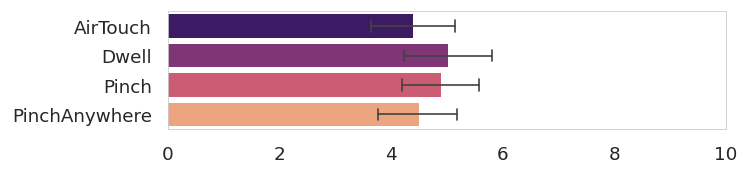

In [5]:
plot, axis = barplot_one_factor(df_tlx, iv="Technique", dv="TLX")
axis.set(xlim=(0, 10))

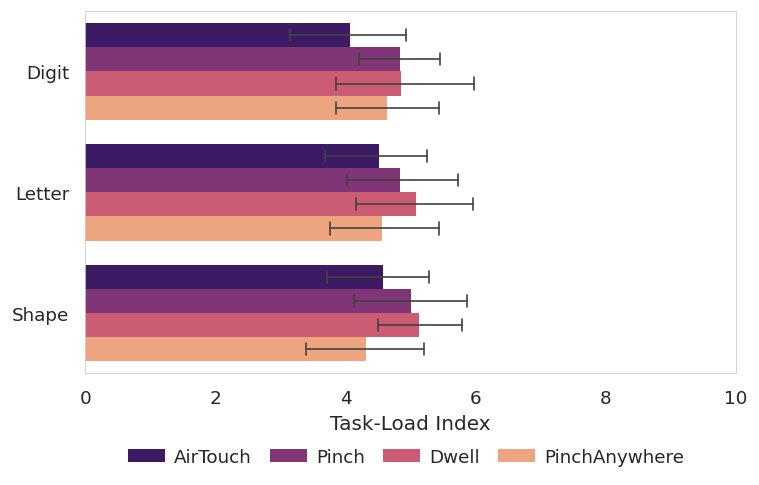

In [6]:
plot, axis = barplot_two_factor(df, iv1="Task", iv2="Technique", dv="TLX", xlab="Task-Load Index", hide_grid=True, hide_legend=False, size=(7, 4))
axis.set(xlim=(0, 10))
axis.legend(handletextpad=0.5, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, -0.3))

## 2.2 TLX Analysis

In [7]:
def friedman(iv="Technique", dv="TLX"):
    """
    Performs a friedman test and, if relevant, post hoc comparisons.
    
    Params:
        dv: Column containing values for comparison.
    """
    result     = stats.friedmanchisquare(df_airtouch[dv], df_dwell[dv], df_pinch[dv], df_pinchany[dv])
    result_str = friedman_to_LaTeX(result)

    print(dv + "\n" + result_str + "\n")
    
    if result[1] < 0.05:
        ph_result     = ph.posthoc_nemenyi_friedman(df_tlx, y_col=dv, group_col=iv, block_col="Participant", melted=True)
        ph_result_str = nemenyi_to_LaTeX(ph_result)
        
        print(ph_result_str)

In [8]:
friedman(iv="Technique", dv="TLX")
friedman(iv="Technique", dv="TLX_Mental")
friedman(iv="Technique", dv="TLX_Physical")
friedman(iv="Technique", dv="TLX_Temporal")
friedman(iv="Technique", dv="TLX_Performance")
friedman(iv="Technique", dv="TLX_Effort")
friedman(iv="Technique", dv="TLX_Frustration")

TLX
$\chi^2 = 8.40, p = 0.038$


TLX_Mental
$\chi^2 = 12.31, p = 0.006$

AirTouch vs Dwell p = 0.016
AirTouch vs Pinch p = 0.020

TLX_Physical
$\chi^2 = 6.44, p = 0.092$

TLX_Temporal
$\chi^2 = 4.18, p = 0.243$

TLX_Performance
$\chi^2 = 1.13, p = 0.771$

TLX_Effort
$\chi^2 = 8.94, p = 0.030$


TLX_Frustration
$\chi^2 = 10.87, p = 0.012$

AirTouch vs Pinch p = 0.016



# 3. Likert scales

In [9]:
# Aggregate survey responses per participant - take median across the different tasks
df_likert = df.groupby(["Participant", "Technique"]).aggregate({"Acquire": "median", "Control": "median", "Move": "median", "Disengage": "median", "Satisfaction": "median", "Retain": "median", "Responsive": "median"}).reset_index()

# Create separate arrays for each technique
df_airtouch = df_likert[df_likert['Technique'] == "AirTouch"]
df_dwell    = df_likert[df_likert['Technique'] == "Dwell"]
df_pinch    = df_likert[df_likert['Technique'] == "Pinch"]
df_pinchany = df_likert[df_likert['Technique'] == "PinchAnywhere"]

# Initialise render parameters for the Likert plots
plt.rcParams['patch.linewidth'] = 0.0
plt.rcParams['lines.linewidth'] = 1.0

# Set up Likert plot values
scale_labels = ["1 Strongly Disagree", "2 Disagree", "3 Slightly Disagree", "4 Neutral", "5 Slightly Agree", "6 Agree", "7 Strongly Agree"]
likert_palette = [(1., 1., 1., 0.)] + sns.color_palette("magma", 7)
questions = ["Acquire", "Control", "Move", "Disengage", "Satisfaction", "Retain", "Responsive"]

## 3.1 Air Touch

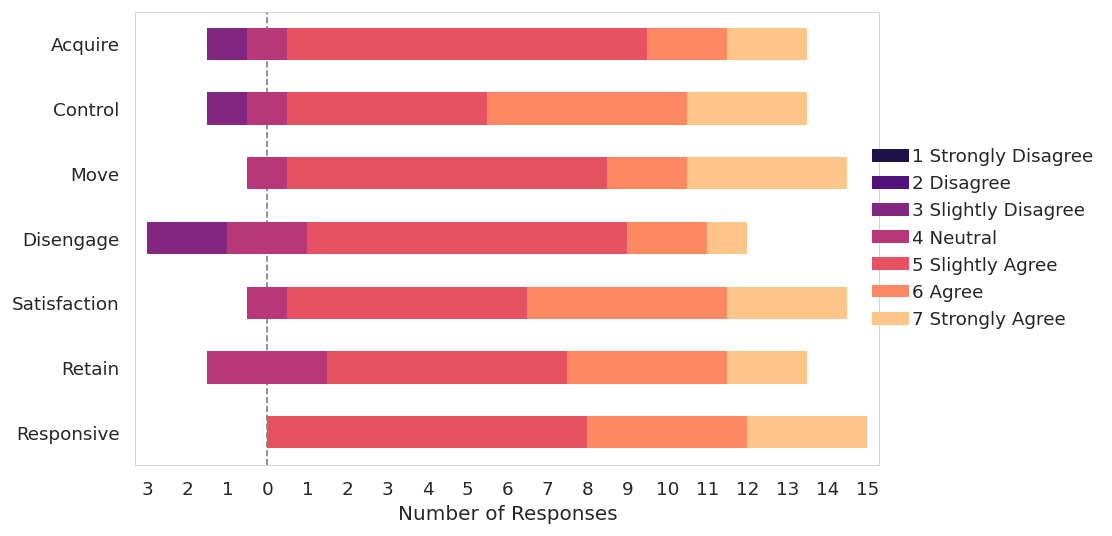

In [10]:
axis = plot_likert.plot_likert(df_airtouch[questions], [1, 2, 3, 4, 5, 6, 7], plot_percentage=False, colors=likert_palette, figsize=(8, 5));
axis.grid(False)
handles, _ = axis.get_legend_handles_labels()
axis.legend(handles, scale_labels, handletextpad=0.2, columnspacing=0.8, loc="center right", ncol=1, frameon=False, bbox_to_anchor=(1.31, 0.5))

## 3.2 Dwell

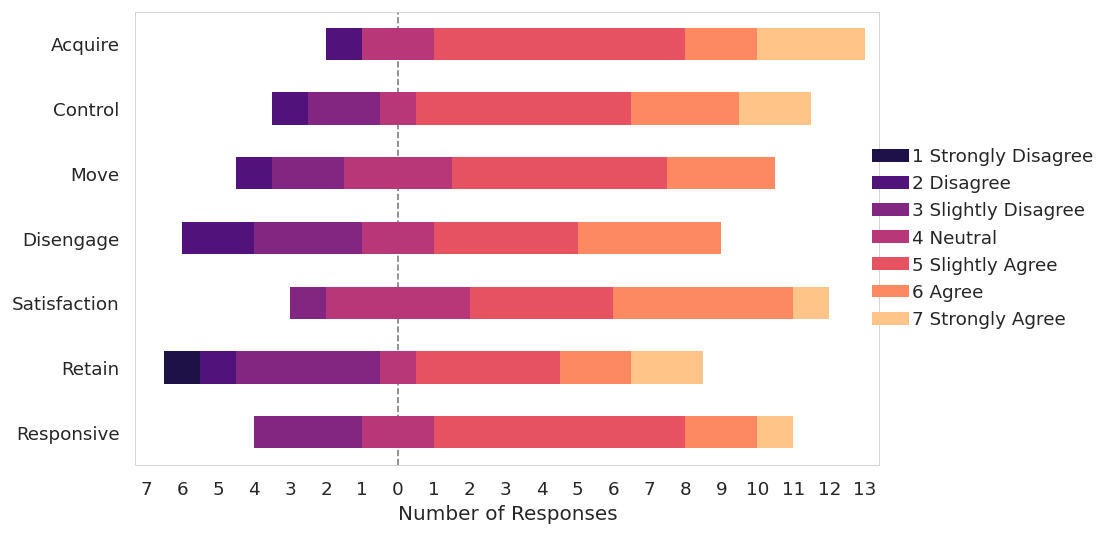

In [11]:
axis = plot_likert.plot_likert(df_dwell[questions], [1, 2, 3, 4, 5, 6, 7], plot_percentage=False, colors=likert_palette, figsize=(8, 5));
axis.grid(False)
handles, _ = axis.get_legend_handles_labels()
axis.legend(handles, scale_labels, handletextpad=0.2, columnspacing=0.8, loc="center right", ncol=1, frameon=False, bbox_to_anchor=(1.31, 0.5))

## 3.3 Pinch

In [12]:
axis = plot_likert.plot_likert(df_pinch[questions], [1, 2, 3, 4, 5, 6, 7], plot_percentage=False, colors=likert_palette, figsize=(8, 5));
axis.grid(False)
handles, _ = axis.get_legend_handles_labels()
axis.legend(handles, scale_labels, handletextpad=0.2, columnspacing=0.8, loc="center right", ncol=1, frameon=False, bbox_to_anchor=(1.31, 0.5))

PlotLikertError: A response was found with value `4.5`, which is not one of the values in the provided scale: [1, 2, 3, 4, 5, 6, 7]. If this is unexpected, you might want to double-check for extra whitespace, capitalization, spelling, or type (int versus str).

## 3.4 Pinch Anywhere

In [ ]:
axis = plot_likert.plot_likert(df_pinchany[questions], [1, 2, 3, 4, 5, 6, 7], plot_percentage=False, colors=likert_palette, figsize=(8, 5));
axis.grid(False)
handles, _ = axis.get_legend_handles_labels()
axis.legend(handles, scale_labels, handletextpad=0.2, columnspacing=0.8, loc="center right", ncol=1, frameon=False, bbox_to_anchor=(1.31, 0.5))